<a href="https://colab.research.google.com/github/vijaynadimpalli/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%203%20-%20NLP/NLP_Week4_Exercise_Shakespeare_Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-10-02 15:04:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.71.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.71.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-10-02 15:04:48 (105 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [4]:
print(max_sequence_len)
print(predictors.shape)
print(label.shape)

11
(15462, 10)
(15462, 3211)


In [5]:
# # Note this is the 100 dimension version of GloVe from Stanford
# # I unzipped and hosted it on my site to make this notebook easier
# word_index = tokenizer.word_index
# embedding_dim = 100

# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
#     -O /tmp/glove.6B.100d.txt
# embeddings_index = {};
# with open('/tmp/glove.6B.100d.txt') as f:
#     for line in f:
#         values = line.split();
#         word = values[0];
#         coefs = np.asarray(values[1:], dtype='float32');
#         embeddings_index[word] = coefs;

# embeddings_matrix = np.zeros((total_words, embedding_dim));
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word);
#     if embedding_vector is not None:
#         embeddings_matrix[i] = embedding_vector;

--2020-10-02 15:04:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.133.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  31.8MB/s    in 10s     

2020-10-02 15:05:00 (31.8 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [18]:
model = Sequential()
model.add(Embedding(total_words,embedding_dim,input_length=max_sequence_len-1)),
model.add(LSTM(128,return_sequences=True)),
model.add(Dropout(0.2)),
model.add(LSTM(128,return_sequences=False))
model.add(Dense(1024,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.001)))
model.add(Dense(total_words,activation='softmax'))
# Pick an optimizer
opt = Adam()
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy']) # Pick a loss function and an optimizer)
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 128)           117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dense_9 (Dense)              (None, 3211)              3291275   
Total params: 3,993,303
Trainable params: 3,993,303
Non-trainable params: 0
____________________________________________

In [19]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 9s 18ms/step - loss: 6.8714 - accuracy: 0.0222
Epoch 2/100
484/484 [==============================] - 9s 18ms/step - loss: 6.5135 - accuracy: 0.0233
Epoch 3/100
484/484 [==============================] - 9s 19ms/step - loss: 6.3992 - accuracy: 0.0294
Epoch 4/100
484/484 [==============================] - 9s 19ms/step - loss: 6.2484 - accuracy: 0.0350
Epoch 5/100
484/484 [==============================] - 9s 18ms/step - loss: 6.1172 - accuracy: 0.0370
Epoch 6/100
484/484 [==============================] - 9s 18ms/step - loss: 5.9852 - accuracy: 0.0393
Epoch 7/100
484/484 [==============================] - 9s 19ms/step - loss: 5.8481 - accuracy: 0.0440
Epoch 8/100
484/484 [==============================] - 9s 19ms/step - loss: 5.7232 - accuracy: 0.0479
Epoch 9/100
484/484 [==============================] - 9s 19ms/step - loss: 5.5748 - accuracy: 0.0563
Epoch 10/100
484/484 [==============================] - 9s 18ms/step - loss: 5.441

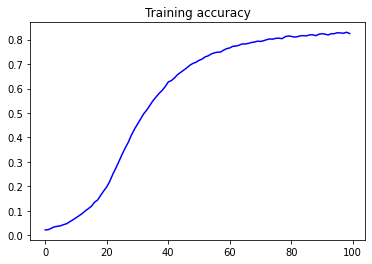

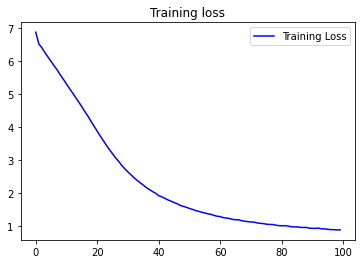

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [16]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope where one ' in sense dyed twain quite near gay dwell as both gems gems still warm'd seen mad mad for rolling twain gems latch it must be true due of thee that i swear so am not thee releasing so great gone made on me must gone will be so so wilt i bring your loss to lie to thee that in me i grow back her tongue hour survey weep loved of nought in doubt more delight bow appear appear in sense away away away away ' both both away of men oppress'd with rolling aspect aspect both
